In [672]:
!pip install Sastrawi
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import re
import string

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import download as nltk_download
nltk_download('punkt')
nltk_download('stopwords')
nltk_download('wordnet')

from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory

from wordcloud import WordCloud

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import accuracy_score, precision_score
from sklearn.preprocessing import LabelEncoder

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, SpatialDropout1D, Conv1D, GlobalMaxPooling1D, Bidirectional, MaxPooling1D, Flatten, GRU, SimpleRNN
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, Callback
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam

import requests
import csv
from io import StringIO
import tensorflow as tf

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [673]:
df = pd.read_csv('datascraping_ovos.csv')

print("Jumlah baris dan kolom:")
print(df.shape)

Jumlah baris dan kolom:
(30000, 11)


In [674]:
df.head()

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion
0,3564d8ad-e8fa-414c-9766-f8b0f76a738b,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2NTXmTsBVtJqk8jxF9rh8ApRWfsIMQSt2uE4OcpQqbFu7f7NbTK05lx80nuSijCz7sc3a277R67g,sering gangguan,3,0,NaN,2025-04-22 14:04:23,NaN,NaN,NaN
1,13f33a6b-a841-43f2-bb39-95fdade32905,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2NTXmTsBVtJqk8jxF9rh8ApRWfsIMQSt2uE4OcpQqbFu7f7NbTK05lx80nuSijCz7sc3a277R67g,ini kenapa GK bisa transfer,1,0,3.132.0,2025-04-22 13:36:58,NaN,NaN,3.132.0
2,87c0196c-d475-46f0-9fc9-c8eed4961ebe,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2NTXmTsBVtJqk8jxF9rh8ApRWfsIMQSt2uE4OcpQqbFu7f7NbTK05lx80nuSijCz7sc3a277R67g,keren,5,0,NaN,2025-04-22 13:17:12,NaN,NaN,NaN
3,2ca00cc5-ead7-46ee-9ab0-4579b5ae10b6,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2NTXmTsBVtJqk8jxF9rh8ApRWfsIMQSt2uE4OcpQqbFu7f7NbTK05lx80nuSijCz7sc3a277R67g,Sudah Bagus dan tingkatkan terus.,5,0,3.132.0,2025-04-22 13:10:30,NaN,NaN,3.132.0
4,328e7955-afbd-46c5-94fd-5476f5e01869,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2NTXmTsBVtJqk8jxF9rh8ApRWfsIMQSt2uE4OcpQqbFu7f7NbTK05lx80nuSijCz7sc3a277R67g,"ribet, kenapa ttup akun di mintain KTP, padahal daftar nya ga pakai KTP",1,0,NaN,2025-04-22 12:58:55,NaN,NaN,NaN


In [675]:
df.columns

Index(['reviewId', 'userName', 'userImage', 'content', 'score',
       'thumbsUpCount', 'reviewCreatedVersion', 'at', 'replyContent',
       'repliedAt', 'appVersion'],
      dtype='object')

In [676]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   reviewId              30000 non-null  object
 1   userName              30000 non-null  object
 2   userImage             30000 non-null  object
 3   content               30000 non-null  object
 4   score                 30000 non-null  int64 
 5   thumbsUpCount         30000 non-null  int64 
 6   reviewCreatedVersion  22651 non-null  object
 7   at                    30000 non-null  object
 8   replyContent          6698 non-null   object
 9   repliedAt             6698 non-null   object
 10  appVersion            22651 non-null  object
dtypes: int64(2), object(9)
memory usage: 2.5+ MB


In [677]:
# Asumsikan df adalah nama DataFrame kamu
for col in df.columns:
    unique_values = df[col].unique()
    print(f"Kolom: {col}")
    print(f"Jumlah item unik: {len(unique_values)}")
    print(f"Contoh item unik: {unique_values[:5]}")
    print("-" * 50)

Kolom: reviewId
Jumlah item unik: 30000
Contoh item unik: ['3564d8ad-e8fa-414c-9766-f8b0f76a738b'
 '13f33a6b-a841-43f2-bb39-95fdade32905'
 '87c0196c-d475-46f0-9fc9-c8eed4961ebe'
 '2ca00cc5-ead7-46ee-9ab0-4579b5ae10b6'
 '328e7955-afbd-46c5-94fd-5476f5e01869']
--------------------------------------------------
Kolom: userName
Jumlah item unik: 1
Contoh item unik: ['Pengguna Google']
--------------------------------------------------
Kolom: userImage
Jumlah item unik: 1
Contoh item unik: ['https://play-lh.googleusercontent.com/EGemoI2NTXmTsBVtJqk8jxF9rh8ApRWfsIMQSt2uE4OcpQqbFu7f7NbTK05lx80nuSijCz7sc3a277R67g']
--------------------------------------------------
Kolom: content
Jumlah item unik: 24104
Contoh item unik: ['sering gangguan' 'ini kenapa GK bisa transfer' 'keren'
 'Sudah Bagus dan tingkatkan terus.'
 'ribet, kenapa ttup akun di mintain KTP, padahal daftar nya ga pakai KTP']
--------------------------------------------------
Kolom: score
Jumlah item unik: 5
Contoh item unik: [3 1 

**Data Preparation**

In [678]:
# 1. Cek info awal
print("Jumlah baris dan kolom:", df.shape)
print("\nInfo dataframe:")
print(df.info())
print("\nJumlah missing value per kolom:")
print(df.isnull().sum())

Jumlah baris dan kolom: (30000, 11)

Info dataframe:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   reviewId              30000 non-null  object
 1   userName              30000 non-null  object
 2   userImage             30000 non-null  object
 3   content               30000 non-null  object
 4   score                 30000 non-null  int64 
 5   thumbsUpCount         30000 non-null  int64 
 6   reviewCreatedVersion  22651 non-null  object
 7   at                    30000 non-null  object
 8   replyContent          6698 non-null   object
 9   repliedAt             6698 non-null   object
 10  appVersion            22651 non-null  object
dtypes: int64(2), object(9)
memory usage: 2.5+ MB
None

Jumlah missing value per kolom:
reviewId                    0
userName                    0
userImage                   0
content   

In [679]:
# 2. Drop kolom yang tidak relevan untuk analisis sentimen
drop_cols = ['reviewId', 'userName', 'userImage', 'reviewCreatedVersion', 'repliedAt', 'replyContent', 'appVersion', 'thumbsUpCount']
df.drop(columns=drop_cols, inplace=True)

In [680]:
df.columns

Index(['content', 'score', 'at'], dtype='object')

In [681]:
# 3. Hapus duplikat
df.drop_duplicates(inplace=True)

In [682]:
# 4. Tangani missing value di kolom `content`
df = df[df['content'].notnull()]

In [683]:
# 5. Ubah tipe data kolom waktu
df['at'] = pd.to_datetime(df['at'])

In [684]:
# 6. Cek kembali hasil pembersihan
print("\nData setelah dibersihkan:")
print(df.info())
df.head()


Data setelah dibersihkan:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   content  30000 non-null  object        
 1   score    30000 non-null  int64         
 2   at       30000 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 703.3+ KB
None


,content,score,at
0,sering gangguan,3,2025-04-22 14:04:23
1,ini kenapa GK bisa transfer,1,2025-04-22 13:36:58
2,keren,5,2025-04-22 13:17:12
3,Sudah Bagus dan tingkatkan terus.,5,2025-04-22 13:10:30
4,"ribet, kenapa ttup akun di mintain KTP, padahal daftar nya ga pakai KTP",1,2025-04-22 12:58:55


In [685]:
# 7. (Opsional) Cek distribusi skor sebagai dasar labeling
print("\nDistribusi skor:")
print(df['score'].value_counts())


Distribusi skor:
score
1    13257
5    12073
2     1784
3     1502
4     1384
Name: count, dtype: int64


In [686]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from collections import Counter

# Download the necessary NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt_tab') # Download the punkt_tab resource

# 1. Melihat isi kolom `content`
print("Contoh isi kolom 'content':")
print(df['content'].head())  # Menampilkan 5 baris pertama

# 2. Mencari kata yang paling banyak keluar
def preprocess_text(text):
    """Melakukan preprocessing teks."""
    text = text.lower()  # Case folding
    tokens = word_tokenize(text)  # Tokenization
    stop_words = set(stopwords.words('english'))  # Stop word removal
    tokens = [token for token in tokens if token.isalnum() and token not in stop_words]
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]  # Lemmatization
    return tokens

# Mengumpulkan semua kata dari kolom 'content'
all_words = []
for text in df['content']:
    all_words.extend(preprocess_text(text))

# Menghitung frekuensi kemunculan setiap kata
word_freq = Counter(all_words)

# Menampilkan 10 kata yang paling sering muncul
print("\n20 kata yang paling sering muncul:")
print(word_freq.most_common(20))

Contoh isi kolom 'content':
0                                                            sering gangguan
1                                                ini kenapa GK bisa transfer
2                                                                      keren
3                                          Sudah Bagus dan tingkatkan terus.
4    ribet, kenapa ttup akun di mintain KTP, padahal daftar nya ga pakai KTP
Name: content, dtype: object


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!



20 kata yang paling sering muncul:
[('ovo', 10348), ('di', 8182), ('saya', 8171), ('bisa', 5944), ('aplikasi', 5195), ('ke', 4800), ('ini', 4437), ('nya', 4293), ('saldo', 4274), ('tidak', 4079), ('ada', 3858), ('masuk', 3810), ('gak', 3455), ('dan', 3368), ('mau', 3244), ('ga', 3135), ('transfer', 2883), ('sudah', 2815), ('sangat', 2782), ('tapi', 2782)]


In [687]:
import re
import string
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

# Unduh stopwords dan tokenizer
nltk.download('punkt')
nltk.download('stopwords')

# 1. Cleaning text
def cleaningText(text):
    text = re.sub(r'@[A-Za-z0-9]+', '', text)  # Hapus mentions
    text = re.sub(r'#[A-Za-z0-9]+', '', text)  # Hapus hashtags
    text = re.sub(r'RT[\s]+', '', text)  # Hapus RT
    text = re.sub(r"http\S+", '', text)  # Hapus links
    text = re.sub(r'[0-9]+', '', text)  # Hapus numbers
    text = re.sub(r'[^\w\s]', '', text)  # Hapus tanda baca
    text = text.replace('\n', ' ')  # Ganti baris baru dengan spasi
    text = text.translate(str.maketrans('', '', string.punctuation))  # Hapus tanda baca lagi
    text = text.strip()  # Hapus spasi di awal dan akhir
    return text

# 2. Case folding
def casefoldingText(text):
    return text.lower()

# 3. Tokenizing
def tokenizingText(text):
    return word_tokenize(text)

def filteringText(text):
    list_stopwords = set(stopwords.words('indonesian'))
    list_stopwords_en = set(stopwords.words('english'))
    list_stopwords.update(list_stopwords_en)

    additional_stopwords = [
    'susah', 'gagal', 'error', 'parah', 'jelek', 'kecewa', 'ribet', 'hilang', 'lelet', 'gak', 'guna',
    'menyesal', 'buruk', 'ditolak', 'anj', 'bermasalah', 'telat', 'anjlok', 'ditahan', 'kocak', 'ngebug',
    'perampok', 'hadeh', 'aplikasi', 'saldo', 'ovo', 'transaksi', 'nya', 'sih', 'tuh', 'ajah', 'aja',
    'banget', 'bikin', 'donlot', 'uang', 'saya', 'ini', 'dan', 'yang', 'ke', 'dari', 'untuk', 'pada',
    'dengan', 'atau', 'tidak', 'itu', 'lebih', 'jika', 'sudah', 'mau', 'bisa', 'kali', 'sama', 'kek',
    'gimana', 'kenapa', 'potong', 'ngurus', 'data', 'kebanyakan', 'kenak', 'saran', 'biaya', 'transfer',
    'mahal', 'pelayanan', 'proses', 'masalah', 'berhasil', 'sulit', 'banyak', 'woy', 'Susah', 'Gagal',
    'Error', 'Parah', 'Jelek', 'Kecewa', 'Ribet', 'Hilang', 'Lelet', 'Gak guna', 'Menyesal', 'Buruk',
    'Ditolak', 'Anj', 'Anjlok', 'Bermasalah', 'Telat', 'Ditahan', 'Kocak', 'Ngebug', 'Perampok', 'Hadeh',
    'woi', 'hai', 'akan', 'tetapi', 'harus', 'sobat', 'lagi', 'ya', 'ga', 'gabisa', 'pa', 'deh', 'blm',
    'gajelas', 'tolong perbaiki', 'dipotong', 'aneh', 'sy', 'kepotong', 'dr', 'biar', 'gangguan', 'rb',
    'kendala', 'ganti', 'tdk', 'jam', 'kakak', 'nunggu', 'bintang', 'x', 'akibat', 'promo', 'bos', 'kaya',
    'si', 'doang', 'nabung', 'perbaiki', 'solusi', 'emang', 'grab', 'ktp', 'solusinya', 'ko', 'utk', 'dah',
    'eh', 'tp', 'masa', 'buat', 'ni', 'ada', 'mana', 'tlong', 'lapor', 'klo', 'soal', 'gua', 'jgn',
    'susah', 'gagal', 'error', 'parah', 'jelek', 'kecewa', 'ribet', 'hilang', 'lelet', 'gak', 'guna',
    'menyesal', 'buruk', 'ditolak', 'anj', 'bermasalah', 'telat', 'anjlok', 'ditahan', 'kocak', 'ngebug',
    'perampok', 'hadeh', 'aplikasi', 'saldo', 'ovo', 'transaksi', 'nya', 'sih', 'tuh', 'ajah', 'aja',
    'banget', 'bikin', 'donlot', 'susah', 'gagal', 'error', 'parah', 'jelek', 'kecewa', 'ribet', 'hilang',
    'lelet', 'gak', 'guna', 'menyesal', 'buruk', 'ditolak', 'anj', 'anjlok', 'bermasalah', 'telat',
    'ditahan', 'kocak', 'ngebug', 'perampok', 'hadeh', 'aplikasi', 'saldo', 'ovo', 'transaksi', 'nya',
    'sih', 'tuh', 'aplikasi', 'uang', 'saya', 'ini', 'dan', 'yang', 'ke', 'dari', 'untuk', 'pada', 'dengan',
    'atau', 'tidak', 'itu', 'lebih', 'jika', 'sudah', 'mau', 'bisa', 'kali', 'sama', 'kek', 'gimana',
    'kenapa', 'potong', 'ngurus', 'data', 'kebanyakan', 'kenak', 'saran', 'biaya', 'transfer', 'mahal',
    'pelayanan', 'proses', 'masalah', 'berhasil', 'sulit', 'banyak', 'gak', 'transfer', 'ovo', 'woy',
    "Susah", "Gagal", "Error", "Parah", "Jelek", "Kecewa", "Ribet", "Hilang", "Lelet", "Gak guna",
    "Menyesal", "Buruk", "Ditolak", "Anj", "Anjlok", "Bermasalah", "Telat", "Ditahan", "Kocak", "Ngebug",
    "Perampok", "Hadeh",'woi','hai','dan','akan','tetapi','harus','sobat','lagi','ya', 'ga', 'gabisa', 'pa', 'deh', 'blm','gajelas', 'tolong perbaiki', 'ga', 'dipotong', 'aneh', 'sy', 'kepotong', 'gajelas', 'blm', 'deh', 'dr', 'biar', 'gangguan', 'rb', 'kendala', 'ganti', 'tdk', 'jam', 'kakak', 'nunggu', 'sy', 'bintang', 'x', 'akibat', 'promo', 'bos', 'kaya', 'gabisa', 'payah', 'si', 'doang', 'nabung', 'perbaiki', 'solusi', 'emang', 'grab', 'ktp', 'payah', 'gajelas', 'tdk', 'solusinya', 'ke', 'ko', 'utk', 'dah', 'eh', 'tp', 'masa', 'buat', 'ni', 'ada', 'mana', 'tlong','lapor', 'klo','soal', 'gua', 'jgn', 'ok', 'top', 'masuk', 'woyy', 'apa', 'mau', 'cuma', 'jadi', 'nya', 'admin', 'adminnya', 'min', 'minnya'
]


    list_stopwords.update(additional_stopwords)

    return [word for word in text if word not in list_stopwords]

# 5. Stemming (Opsional, tidak dipakai default)
def stemmingText(text):
    factory = StemmerFactory()
    stemmer = factory.create_stemmer()
    return ' '.join([stemmer.stem(word) for word in text.split()])

# 6. To sentence
def toSentence(list_words):
    return ' '.join(list_words)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [688]:
# print(df[['content', 'score']].head(500).to_string())

In [689]:
import pandas as pd
from collections import Counter
import re

# Misal df sudah berisi data tweet, kolom 'content'
# Contoh: df = pd.read_csv('data_tweet.csv')

def cleaningText(text):
    text = re.sub(r'[^\w\s]', '', text)  # Hapus tanda baca
    text = text.lower()  # Lowercase
    return text

# Gabungkan semua tweet jadi satu string besar
all_text = ' '.join(df['content'].astype(str).apply(cleaningText))

# Tokenisasi manual (split by space)
all_words = all_text.split()

# Hitung frekuensi kata
word_counts = Counter(all_words)

# Ambil kata unik (yang muncul hanya sekali)
unique_words = [word for word, count in word_counts.items() if count == 1]

print("Kata-kata unik (muncul sekali saja):")
print(unique_words[:2500])  # Tampilkan 100 kata unik pertama

# Jika ingin kata unik yang tidak termasuk stopwords:
from nltk.corpus import stopwords
stopwords_id = set(stopwords.words('indonesian'))
# Tambahkan stopwords tambahan jika perlu

unique_words_clean = [w for w in unique_words if w not in stopwords_id]
print("\nKata unik tanpa stopwords:")
print(unique_words_clean[:2500])


Kata-kata unik (muncul sekali saja):
['2242025', '1925', 'muluno', 'masukternyata', 'maker', 'blokiraneh', '𝚊𝚙𝚕𝚒𝚔𝚊𝚜𝚒', '𝚙𝚊𝚕𝚒𝚗𝚐', '𝚜𝚊𝚖𝚙𝚊𝚑', '𝚜𝚞𝚖𝚙𝚊𝚑', '𝚖𝚗𝚍𝚒𝚗𝚐', '𝚙𝚊𝚔𝚎', '𝚍𝚊𝚗𝚊', '𝚊𝚓', 'malingsaya', 'prosesdasar', 'terlengkap', 'besarin', 'mbnya', 'pembatasan', 'nyamanapapn', 'inipercuma', 'iniapakah', 'ovotrimksh', 'ovomales', 'siiii', 'baguscuma', 'errortolonh', '1997000', 'matre', 'bjiirrr', 'ngambilnya', 'robux', 'gagak', 'aplikasimau', 'mainkalah', 'masuk2dalam', 'kesiapa', 'pakekpadahal', 'kemrn', 'ilegalbuat', 'ovomana', 'inikemarin', '160', 'ovosekarng', 'premierpadahal', 'sarannyaapk', 'trensfer', 'teratasiterselesaikan', '760500', 'ribumasak', 'sendiridgn', 'susahdikirim', 'bisakacau', '985', 'coook', 'miskinuninstal', 'bangkeeeee', 'sampaaaah', 'nomorku', 'playeter', 'kepotonh', 'parahgak', 'nerimauangku', 'pembayarannyaa', 'agennya', 'ngbug', 'pegal', 'memposisikan', 'stengah', 'tolonng', 'keliatanya', 'sippzz', 'kuran', 'bregsek', 'mantaaf', 'aflikasinya', 'belsan', 'bangst', 

In [690]:
slangwords = {
    "tf": "transfer", "yg": "yang", "udh": "sudah", "gk": "tidak",
    "@": "di", "abis": "habis", "wtb": "beli", "masi": "masih", "wts": "jual", "wtt": "tukar",
    "bgt": "banget", "maks": "maksimal", "plisss": "tolong", "bgttt": "banget", "indo": "indonesia",
    "bgtt": "banget", "ad": "ada", "rv": "redvelvet", "plis": "tolong", "pls": "tolong", "cr": "sumber",
    "cod": "bayar ditempat", "adlh": "adalah", "afaik": "as far as i know", "ahaha": "haha", "aj": "saja",
    "ajep-ajep": "dunia gemerlap", "ak": "saya", "akika": "aku", "akkoh": "aku", "akuwh": "aku", "alay": "norak",
    "alow": "halo", "ambilin": "ambilkan", "ancur": "hancur", "anjrit": "anjing", "anter": "antar",
    "ap2": "apa-apa", "apasih": "apa sih", "apes": "sial", "aps": "apa", "aq": "saya", "aquwh": "aku", "asbun": "asal bunyi",
    "aseekk": "asyik", "asekk": "asyik", "asem": "asam", "aspal": "asli tetapi palsu", "astul": "asal tulis",
    "ato": "atau", "au ah": "tidak mau tahu", "awak": "saya", "ay": "sayang", "ayank": "sayang", "b4": "sebelum",
    "bakalan": "akan", "bandes": "bantuan desa", "bangedh": "banget", "banpol": "bantuan polisi", "banpur": "bantuan tempur",
    "basbang": "basi", "bcanda": "bercanda", "bdg": "bandung", "begajulan": "nakal", "beliin": "belikan",
    "bencong": "banci", "bentar": "sebentar", "ber3": "bertiga", "beresin": "membereskan", "bete": "bosan", "beud": "banget",
    "bg": "abang", "bgmn": "bagaimana", "bgt": "banget", "bijimane": "bagaimana", "bintal": "bimbingan mental",
    "bkl": "akan", "bknnya": "bukannya", "blegug": "bodoh", "blh": "boleh", "bln": "bulan", "blum": "belum", "bnci": "benci",
    "bnran": "yang benar", "bodor": "lucu", "bokap": "ayah", "boker": "buang air besar", "bokis": "bohong", "boljug": "boleh juga",
    "bonek": "bocah nekat", "boyeh": "boleh", "br": "baru", "brg": "bareng", "bro": "saudara laki-laki", "bru": "baru",
    "bs": "bisa", "bsen": "bosan", "bt": "buat", "btw": "ngomong-ngomong", "buaya": "tidak setia", "bubbu": "tidur", "bubu": "tidur",
    "bumil": "ibu hamil", "bw": "bawa", "bwt": "buat", "byk": "banyak", "byrin": "bayarkan", "cabal": "sabar", "cadas": "keren",
    "calo": "makelar", "can": "belum", "capcus": "pergi", "caper": "cari perhatian", "ce": "cewek", "cekal": "cegah tangkal",
    "cemen": "penakut", "cengengesan": "tertawa", "cepet": "cepat", "cew": "cewek", "chuyunk": "sayang", "cimeng": "ganja",
    "cipika cipiki": "cium pipi kanan cium pipi kiri", "ciyh": "sih", "ckepp": "cakep", "ckp": "cakep", "cmiiw": "correct me if i'm wrong",
    "cmpur": "campur", "cong": "banci", "conlok": "cinta lokasi", "cowwyy": "maaf", "cp": "siapa", "cpe": "capek", "cppe": "capek",
    "cucok": "cocok", "cuex": "cuek", "cumi": "Cuma miscall", "cups": "culun", "curanmor": "pencurian kendaraan bermotor",
    "curcol": "curahan hati colongan", "cwek": "cewek", "cyin": "cinta", "d": "di", "dah": "deh", "dapet": "dapat", "de": "adik",
    "dek": "adik", "demen": "suka", "deyh": "deh", "dgn": "dengan", "diancurin": "dihancurkan", "dimaafin": "dimaafkan",
    "dimintak": "diminta", "disono": "di sana", "dket": "dekat", "dkk": "dan kawan-kawan", "dll": "dan lain-lain", "dlu": "dulu",
    "dngn": "dengan", "dodol": "bodoh", "doku": "uang", "dongs": "dong", "dpt": "dapat", "dri": "dari", "drmn": "darimana",
    "drtd": "dari tadi", "dst": "dan seterusnya", "dtg": "datang", "duh": "aduh", "duren": "durian", "ed": "edisi", "egp": "emang gue pikirin",
    "eke": "aku", "elu": "kamu", "emangnya": "memangnya", "emng": "memang", "endak": "tidak", "enggak": "tidak", "envy": "iri",
    "ex": "mantan", "fax": "facsimile", "fifo": "first in first out", "folbek": "follow back", "fyi": "sebagai informasi",
    "gaada": "tidak ada uang", "gag": "tidak", "gaje": "tidak jelas", "gak papa": "tidak apa-apa", "gan": "juragan", "gaptek": "gagap teknologi",
    "gatek": "gagap teknologi", "gawe": "kerja", "gbs": "tidak bisa", "gebetan": "orang yang disuka", "geje": "tidak jelas",
    "gepeng": "gelandangan dan pengemis", "ghiy": "lagi", "gile": "gila", "gimana": "bagaimana", "gino": "gigi nongol", "githu": "gitu",
    "gj": "tidak jelas", "gmana": "bagaimana", "gn": "begini", "goblok": "bodoh", "golput": "golongan putih", "gowes": "mengayuh sepeda",
    "gpny": "tidak punya", "gr": "gede rasa", "gretongan": "gratisan", "gtau": "tidak tahu", "gua": "saya", "guoblok": "goblok",
    "gw": "saya", "ha": "tertawa", "haha": "tertawa", "hallow": "halo", "hankam": "pertahanan dan keamanan", "hehe": "he", "helo": "halo",
    "hey": "hai", "hlm": "halaman", "hny": "hanya", "hoax": "isu bohong", "hr": "hari", "hrus": "harus", "hubdar": "perhubungan darat",
    "huff": "mengeluh", "hum": "rumah", "humz": "rumah", "ilang": "hilang", "ilfil": "tidak suka", "imho": "in my humble opinion",
    "imoetz": "imut", "item": "hitam", "itungan": "hitungan", "iye": "iya", "ja": "saja", "jadiin": "jadi", "jaim": "jaga image",
    "jayus": "tidak lucu", "jdi": "jadi", "jem": "jam", "jga": "juga"
}

def fix_slangwords(text):
    words = text.split()
    fixed_words = []

    for word in words:
        if word.lower() in slangwords:
            fixed_words.append(slangwords[word.lower()])
        else:
            fixed_words.append(word)

    fixed_text = ' '.join(fixed_words)
    return fixed_text


In [691]:
# Menampilkan dataset yang belum dibersihkan
df = df
df.head(10)

,content,score,at
0,sering gangguan,3,2025-04-22 14:04:23
1,ini kenapa GK bisa transfer,1,2025-04-22 13:36:58
2,keren,5,2025-04-22 13:17:12
3,Sudah Bagus dan tingkatkan terus.,5,2025-04-22 13:10:30
4,"ribet, kenapa ttup akun di mintain KTP, padahal daftar nya ga pakai KTP",1,2025-04-22 12:58:55
5,"buka akun ga pakai ktp, kenapa tutup akun dimintain KTP",2,2025-04-22 12:55:30
6,bagus,5,2025-04-22 12:53:44
7,lelet kdang ga bisa di buka aplikasi nya,1,2025-04-22 12:47:24
8,sangat bagus,5,2025-04-22 12:43:49
9,"sekarang ini saya mau transver gagal terus ,udah dari sehabis lebaran ...",2,2025-04-22 12:37:16


In [692]:
# Create a copy of the original DataFrame to avoid modifying the original data
clean_df = df.copy()

# Membersihkan teks dan menyimpannya di kolom 'text_clean'
clean_df['text_clean'] = clean_df['content'].apply(cleaningText)

# Mengubah huruf dalam teks menjadi huruf kecil dan menyimpannya di 'text_casefoldingText'
clean_df['text_casefoldingText'] = clean_df['text_clean'].apply(casefoldingText)

# Mengganti kata-kata slang dengan kata-kata standar dan menyimpannya di 'text_slangwords'
clean_df['text_slangwords'] = clean_df['text_casefoldingText'].apply(fix_slangwords)

# Memecah teks menjadi token (kata-kata) dan menyimpannya di 'text_tokenizingText'
clean_df['text_tokenizingText'] = clean_df['text_slangwords'].apply(tokenizingText)

# Menghapus kata-kata stop (kata-kata umum) dan menyimpannya di 'text_stopword'
clean_df['text_stopword'] = clean_df['text_tokenizingText'].apply(filteringText)

# Menggabungkan token-token menjadi kalimat dan menyimpannya di 'text_akhir'
clean_df['text_akhir'] = clean_df['text_stopword'].apply(toSentence)

In [693]:
# Menampilkan dataset setelah preprocessing text
clean_df.head(10)

,content,score,at,text_clean,text_casefoldingText,text_slangwords,text_tokenizingText,text_stopword,text_akhir
0,sering gangguan,3,2025-04-22 14:04:23,sering gangguan,sering gangguan,sering gangguan,"[sering, gangguan]",[],
1,ini kenapa GK bisa transfer,1,2025-04-22 13:36:58,ini kenapa gk bisa transfer,ini kenapa gk bisa transfer,ini kenapa tidak bisa transfer,"[ini, kenapa, tidak, bisa, transfer]",[],
2,keren,5,2025-04-22 13:17:12,keren,keren,keren,[keren],[keren],keren
3,Sudah Bagus dan tingkatkan terus.,5,2025-04-22 13:10:30,sudah bagus dan tingkatkan terus,sudah bagus dan tingkatkan terus,sudah bagus dan tingkatkan terus,"[sudah, bagus, dan, tingkatkan, terus]","[bagus, tingkatkan]",bagus tingkatkan
4,"ribet, kenapa ttup akun di mintain KTP, padahal daftar nya ga pakai KTP",1,2025-04-22 12:58:55,ribet kenapa ttup akun di mintain ktp padahal daftar nya ga pakai ktp,ribet kenapa ttup akun di mintain ktp padahal daftar nya ga pakai ktp,ribet kenapa ttup akun di mintain ktp padahal daftar nya ga pakai ktp,"[ribet, kenapa, ttup, akun, di, mintain, ktp, padahal, daftar, nya, ga, pakai, ktp]","[ttup, akun, mintain, daftar, pakai]",ttup akun mintain daftar pakai
5,"buka akun ga pakai ktp, kenapa tutup akun dimintain KTP",2,2025-04-22 12:55:30,buka akun ga pakai ktp kenapa tutup akun dimintain ktp,buka akun ga pakai ktp kenapa tutup akun dimintain ktp,buka akun ga pakai ktp kenapa tutup akun dimintain ktp,"[buka, akun, ga, pakai, ktp, kenapa, tutup, akun, dimintain, ktp]","[buka, akun, pakai, tutup, akun, dimintain]",buka akun pakai tutup akun dimintain
6,bagus,5,2025-04-22 12:53:44,bagus,bagus,bagus,[bagus],[bagus],bagus
7,lelet kdang ga bisa di buka aplikasi nya,1,2025-04-22 12:47:24,lelet kdang ga bisa di buka aplikasi nya,lelet kdang ga bisa di buka aplikasi nya,lelet kdang ga bisa di buka aplikasi nya,"[lelet, kdang, ga, bisa, di, buka, aplikasi, nya]","[kdang, buka]",kdang buka
8,sangat bagus,5,2025-04-22 12:43:49,sangat bagus,sangat bagus,sangat bagus,"[sangat, bagus]",[bagus],bagus
9,"sekarang ini saya mau transver gagal terus ,udah dari sehabis lebaran ...",2,2025-04-22 12:37:16,sekarang ini saya mau transver gagal terus udah dari sehabis lebaran,sekarang ini saya mau transver gagal terus udah dari sehabis lebaran,sekarang ini saya mau transver gagal terus udah dari sehabis lebaran,"[sekarang, ini, saya, mau, transver, gagal, terus, udah, dari, sehabis, lebaran]","[transver, udah, sehabis, lebaran]",transver udah sehabis lebaran


Mengunduh lexicon positive dan negative dari github.

In [694]:
# Loads positive lexicon data from GitHub
# Membaca data kamus kata-kata positif dari GitHub
lexicon_positive = dict()

response = requests.get('https://raw.githubusercontent.com/angelmetanosaa/dataset/main/lexicon_positive.csv')
reader = csv.reader(StringIO(response.text), delimiter=',')
for row in reader:
    lexicon_positive[row[0]] = int(row[1])


# Loads negative lexicon data from GitHub
# Membaca data kamus kata-kata negatif dari GitHub
lexicon_negative = dict()

response = requests.get('https://raw.githubusercontent.com/angelmetanosaa/dataset/main/lexicon_negative.csv')
reader = csv.reader(StringIO(response.text), delimiter=',')
for row in reader:
    lexicon_negative[row[0]] = int(row[1])

In [695]:
# Fungsi untuk menentukan polaritas sentimen dari tweet

def sentiment_analysis_lexicon_indonesia(text):
    score = 0
    # Check if text is a list and join it into a string if necessary
    if isinstance(text, list):
        text = ' '.join(text)

    # Mengulangi setiap kata dalam teks
    for word in text.split():
        # Jika kata ada dalam kamus positif, tambahkan skornya ke skor sentimen
        if word in lexicon_positive:
            score += lexicon_positive[word]

    # Mengulangi setiap kata dalam teks untuk mengecek kamus negatif
    for word in text.split():
        # Jika kata ada dalam kamus negatif, kurangkan skornya dari skor sentimen
        if word in lexicon_negative:
            score += lexicon_negative[word]

    polarity=''

    if score >= 0:
        polarity = 'positive'
    elif score <= -3:
        polarity = 'negative'
    else:
        polarity = 'neutral'

    return score, polarity

In [696]:
# Memberi label pada text
results = clean_df['text_stopword'].apply(sentiment_analysis_lexicon_indonesia)
results = list(zip(*results))
clean_df['polarity_score'] = results[0]
clean_df['polarity'] = results[1]
print(clean_df['polarity'].value_counts())

polarity
positive    19879
negative     6220
neutral      3901
Name: count, dtype: int64


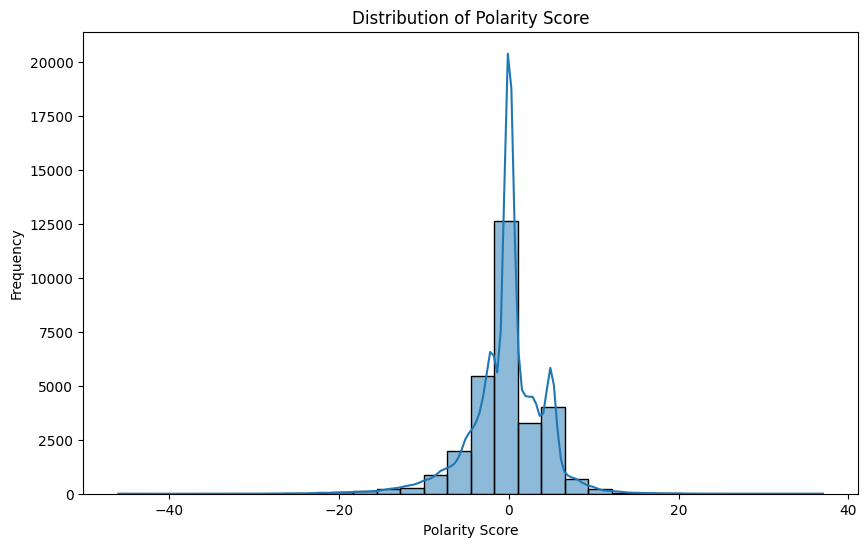

In [697]:
# Menampilkan distribusi polarity_score dengan histogram
plt.figure(figsize=(10, 6))
sns.histplot(clean_df['polarity_score'], bins=30, kde=True)  # Ganti dengan kolom 'score' yang ada di dataset Anda
plt.title('Distribution of Polarity Score')
plt.xlabel('Polarity Score')
plt.ylabel('Frequency')
plt.show()


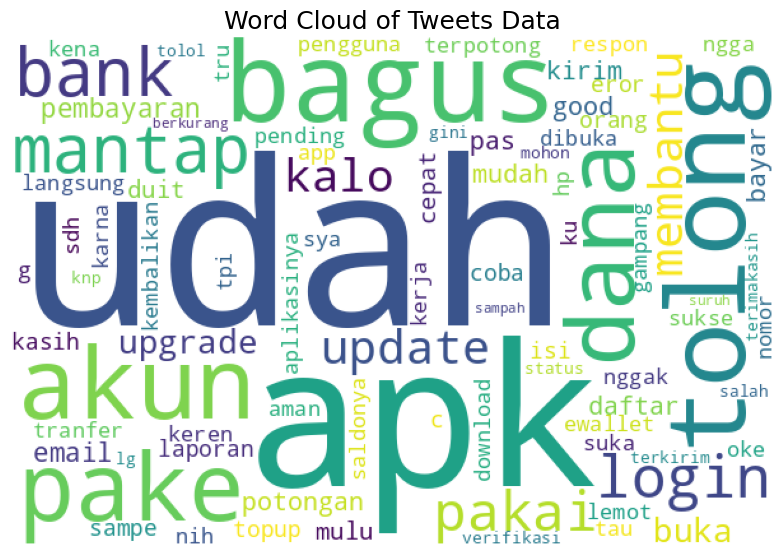

In [698]:
# Membuat wordcloud secara umum

list_words = ''

for tweet in clean_df['text_stopword']:
    # Iterasi melalui setiap kata dalam tweet.
    for word in tweet:
        # Menambahkan kata ke dalam 'list_words'.
        list_words += ' ' + (word)

wordcloud = WordCloud(width=600, height=400, background_color='white', min_font_size=10).generate(list_words)

fig, ax = plt.subplots(figsize=(8, 6))
ax.set_title('Word Cloud of Tweets Data', fontsize=18)
ax.grid(False)
ax.imshow((wordcloud))
fig.tight_layout(pad=0)
ax.axis('off')
plt.show()

In [699]:
# Membuat dataframe untuk wordcloud positive
pd.set_option('display.max_colwidth', 3000)

positive_tweets = clean_df[clean_df['polarity'] == 'positive']
positive_tweets = positive_tweets[['text_akhir', 'polarity_score', 'polarity','text_stopword']]
positive_tweets = positive_tweets.sort_values(by='polarity_score', ascending=False)
positive_tweets = positive_tweets.reset_index(drop=True)
positive_tweets.index += 1

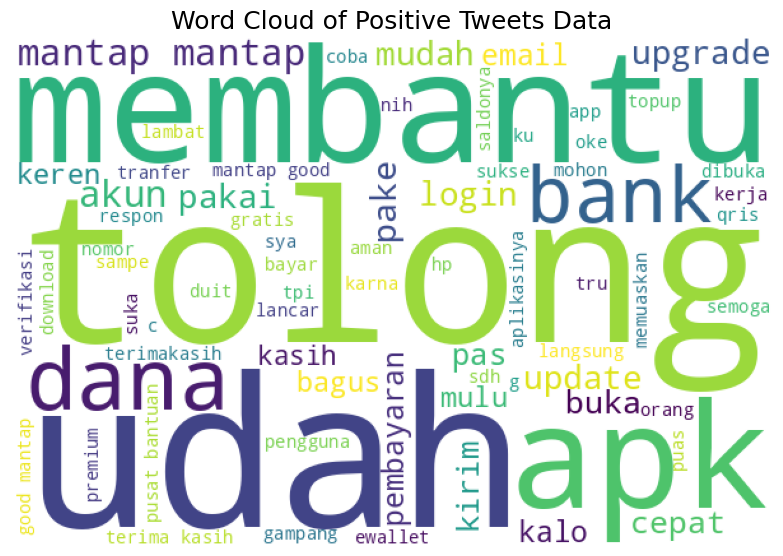

In [700]:
# Menampilkan wordcloud untuk label positive
list_words = ''

# Iterasi melalui setiap tweet dalam kolom 'text_stopword' dari DataFrame 'positive_tweets'.
for tweet in positive_tweets['text_stopword']:
    # Iterasi melalui setiap kata dalam tweet.
    for word in tweet:
        # Menambahkan kata ke dalam 'list_words'.
        list_words += ' ' + (word)

wordcloud = WordCloud(width=600, height=400, background_color='white', min_font_size=10).generate(list_words)

fig, ax = plt.subplots(figsize=(8, 6))
ax.set_title('Word Cloud of Positive Tweets Data', fontsize=18)
ax.grid(False)
ax.imshow((wordcloud))
fig.tight_layout(pad=0)
ax.axis('off')

plt.show()

In [701]:
# Membuat dataframe untuk wordcloud negative
pd.set_option('display.max_colwidth', 3000)

negative_tweets = clean_df[clean_df['polarity'] == 'negative']
negative_tweets = negative_tweets[['text_akhir', 'polarity_score', 'polarity','text_stopword']]
negative_tweets = negative_tweets.sort_values(by='polarity_score', ascending=False)
negative_tweets = negative_tweets.reset_index(drop=True)
negative_tweets.index += 1

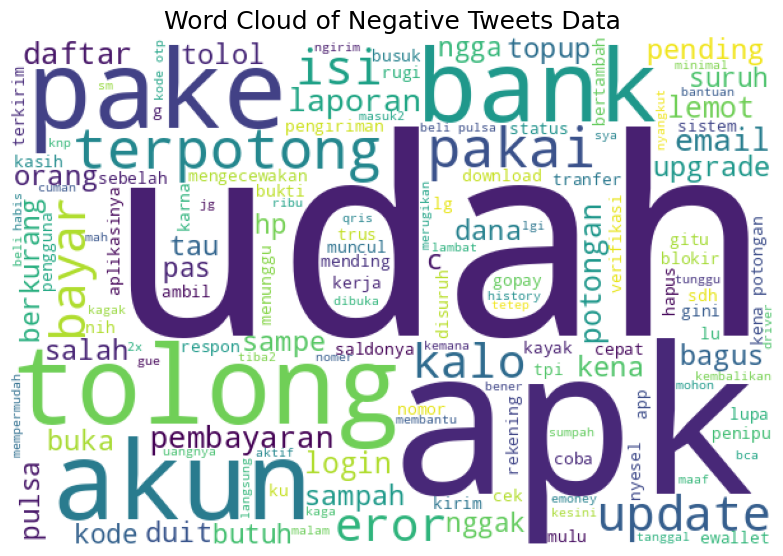

In [702]:
# Menampilkan wordcloud untuk label negative
list_words = ''

# Iterasi melalui setiap tweet dalam kolom 'text_stopword' dari DataFrame 'negative_tweets'.
for tweet in negative_tweets['text_stopword']:
    # Iterasi melalui setiap kata dalam tweet.
    for word in tweet:
        # Menambahkan kata ke dalam 'list_words'.
        list_words += ' ' + (word)

wordcloud = WordCloud(width=600, height=400, background_color='white', min_font_size=10).generate(list_words)

fig, ax = plt.subplots(figsize=(8, 6))
ax.set_title('Word Cloud of Negative Tweets Data', fontsize=18)
ax.grid(False)
ax.imshow((wordcloud))
fig.tight_layout(pad=0)
ax.axis('off')

plt.show()

In [703]:
# Membuat dataframe untuk wordcloud neutral
pd.set_option('display.max_colwidth', 3000)

neutral_tweets = clean_df[clean_df['polarity'] == 'neutral']
neutral_tweets = neutral_tweets[['text_akhir', 'polarity_score', 'polarity','text_stopword']]
neutral_tweets = neutral_tweets.sort_values(by='polarity_score', ascending=False)
neutral_tweets = neutral_tweets.reset_index(drop=True)
neutral_tweets.index += 1

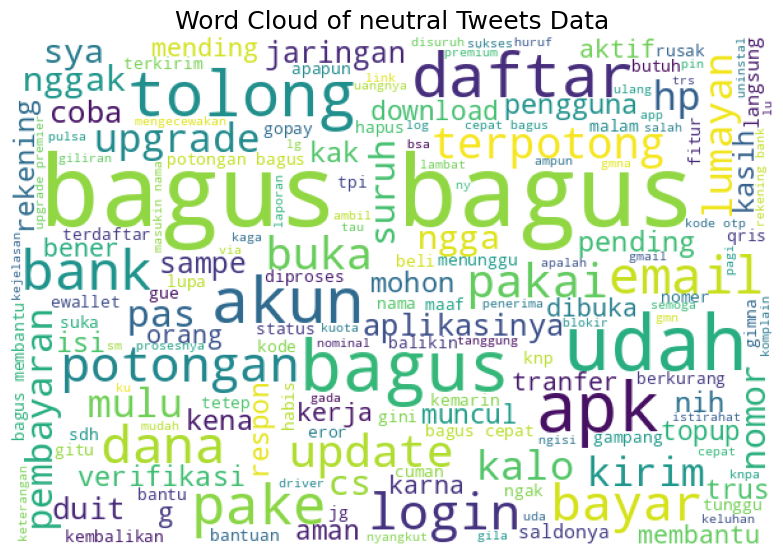

In [704]:
# Menampilkan wordcloud untuk label neutral
list_words = ''

# Iterasi melalui setiap tweet dalam kolom 'text_stopword' dari DataFrame 'neutral_tweets'.
for tweet in neutral_tweets['text_stopword']:
    # Iterasi melalui setiap kata dalam tweet.
    for word in tweet:
        # Menambahkan kata ke dalam 'list_words'.
        list_words += ' ' + (word)

wordcloud = WordCloud(width=600, height=400, background_color='white', min_font_size=10).generate(list_words)

fig, ax = plt.subplots(figsize=(8, 6))
ax.set_title('Word Cloud of neutral Tweets Data', fontsize=18)
ax.grid(False)
ax.imshow((wordcloud))
fig.tight_layout(pad=0)
ax.axis('off')

plt.show()

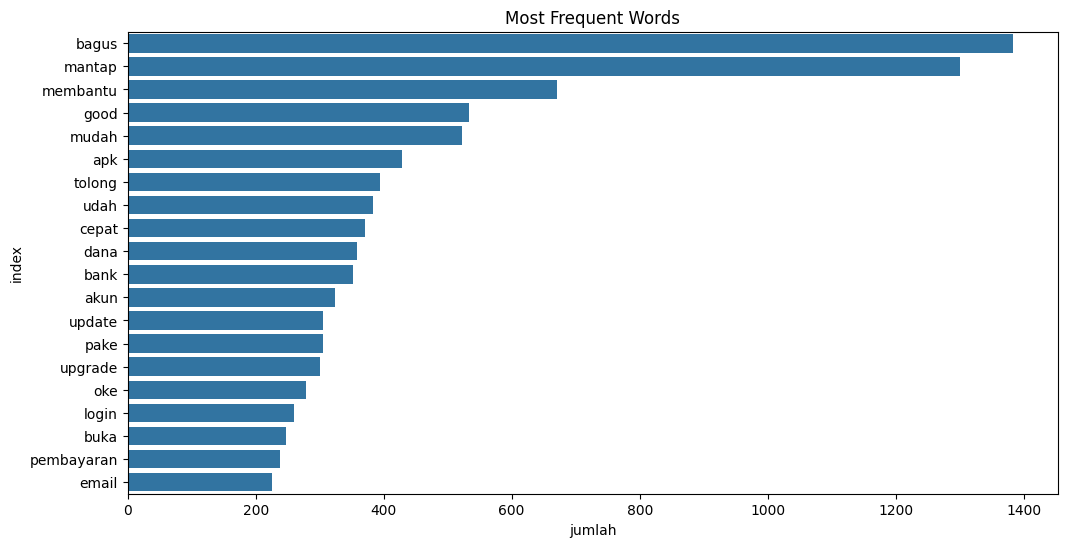

In [705]:
# Set the figure size
plt.figure(figsize=(12, 6))

# Visualize most frequent words
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(clean_df['text_akhir'])
tfidf_df = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())
tfidf_df = tfidf_df.sum().reset_index(name='jumlah')
tfidf_df = tfidf_df.sort_values('jumlah', ascending=False).head(20)
sns.barplot(x='jumlah', y='index', data=tfidf_df)
plt.title('Most Frequent Words')
plt.show()

Modeling \
Pembuatan model dengan melakukan tiga percobaan skema pelatihan yang berbeda dan dibedakan dengan variasi dari dua kombinasi seperti berikut:

- Model 1 Algoritma Pelatihan: LSTM
- Model 2 Algoritma Pelatihan: CNN
- Model 3 Algoritma Pelatihan: GRU

In [716]:
# Mengambil kolom text_akhir dan polarity
X = clean_df['text_akhir']
y = clean_df['polarity']

In [717]:
# Tokenisasi
max_features = 2500
tokenizer = Tokenizer(num_words=max_features, split=' ')
tokenizer.fit_on_texts(X.values)
X = tokenizer.texts_to_sequences(X.values)
X = pad_sequences(X)

# Label encoding
labelencoder = LabelEncoder()
integer_encoded = labelencoder.fit_transform(y)
y = to_categorical(integer_encoded)

# Menentukan jumlah kelas
num_classes = y.shape[1]

In [718]:
class customPassed(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if logs.get('val_accuracy') > 0.90:
            print(f"\nVal accuracy telah melebihi 0.90, menghentikan pelatihan pada epoch {epoch+1}")
            self.model.stop_training = True

berhentiepoch = customPassed()


In [719]:
# Split data
X_train_val, X_test_LSTM, y_train_val, y_test_LSTM = train_test_split(X, y, test_size=0.1, random_state=42)
X_train_LSTM, X_val_LSTM, y_train_LSTM, y_val_LSTM = train_test_split(X_train_val, y_train_val, test_size=2/9, random_state=42)

# Model LSTM
model_LSTM = Sequential([
    Embedding(max_features, 256, input_length=X.shape[1]),
    LSTM(128, dropout=0.2, recurrent_dropout=0.2, kernel_regularizer=l2(0.01), return_sequences=True),
    LSTM(64, dropout=0.2, recurrent_dropout=0.2, kernel_regularizer=l2(0.01)),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(num_classes, activation='softmax')
])

model_LSTM.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

history_LSTM = model_LSTM.fit(
    X_train_LSTM, y_train_LSTM,
    epochs=50,
    batch_size=2056,
    validation_data=(X_val_LSTM, y_val_LSTM),
    callbacks=[berhentiepoch], # Changed custom_callback to berhentiepoch
    verbose=2
)

score_LSTM, acc_LSTM = model_LSTM.evaluate(X_test_LSTM, y_test_LSTM, verbose=2)
print(f"Test score: {score_LSTM:.2f}")
print(f"Test accuracy: {acc_LSTM:.2f}")

model_LSTM.save('model_LSTM.h5')

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


11/11 - 66s - 6s/step - accuracy: 0.5844 - loss: 5.3961 - val_accuracy: 0.6587 - val_loss: 4.4500
Epoch 2/50
11/11 - 47s - 4s/step - accuracy: 0.6689 - loss: 3.9308 - val_accuracy: 0.6693 - val_loss: 3.2772
Epoch 3/50
11/11 - 81s - 7s/step - accuracy: 0.6753 - loss: 2.9136 - val_accuracy: 0.6878 - val_loss: 2.4475
Epoch 4/50
11/11 - 81s - 7s/step - accuracy: 0.6877 - loss: 2.1939 - val_accuracy: 0.6917 - val_loss: 1.8652
Epoch 5/50
11/11 - 46s - 4s/step - accuracy: 0.7027 - loss: 1.6869 - val_accuracy: 0.7278 - val_loss: 1.4385
Epoch 6/50
11/11 - 82s - 7s/step - accuracy: 0.7378 - loss: 1.2843 - val_accuracy: 0.7707 - val_loss: 1.0544
Epoch 7/50
11/11 - 83s - 8s/step - accuracy: 0.7873 - loss: 0.9453 - val_accuracy: 0.7963 - val_loss: 0.8192
Epoch 8/50
11/11 - 81s - 7s/step - accuracy: 0.8413 - loss: 0.7214 - val_accuracy: 0.8450 - val_loss: 0.6606
Epoch 9/50
11/11 - 82s - 7s/step - accuracy: 0.8656 - loss: 0.5726 - val_accuracy: 0.8662 - val_loss: 0.5488
Epoch 10/50
11/11 - 82s - 7s/s

Test score: 0.33
Test accuracy: 0.92


In [720]:
# Split data
X_train_val, X_test_CNN, y_train_val, y_test_CNN = train_test_split(X, y, test_size=0.1, random_state=42)
X_train_CNN, X_val_CNN, y_train_CNN, y_val_CNN = train_test_split(X_train_val, y_train_val, test_size=1/9, random_state=42)

# Model CNN
model_CNN = Sequential([
    Embedding(max_features, 512, input_length=X.shape[1]),
    Conv1D(64, kernel_size=5, activation='relu'),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

model_CNN.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

history_CNN = model_CNN.fit(
    X_train_CNN, y_train_CNN,
    epochs=50,
    batch_size=2056,
    validation_data=(X_val_CNN, y_val_CNN),
    callbacks=[berhentiepoch],
    verbose=2
)

score_CNN, acc_CNN = model_CNN.evaluate(X_test_CNN, y_test_CNN, verbose=2)
print(f"Test score: {score_CNN:.2f}")
print(f"Test accuracy: {acc_CNN:.2f}")

model_CNN.save('model_CNN.h5')

Epoch 1/50
12/12 - 36s - 3s/step - accuracy: 0.6196 - loss: 0.9033 - val_accuracy: 0.6783 - val_loss: 0.8072
Epoch 2/50
12/12 - 40s - 3s/step - accuracy: 0.6960 - loss: 0.7894 - val_accuracy: 0.7233 - val_loss: 0.7274
Epoch 3/50
12/12 - 40s - 3s/step - accuracy: 0.7568 - loss: 0.6708 - val_accuracy: 0.7750 - val_loss: 0.5708
Epoch 4/50
12/12 - 41s - 3s/step - accuracy: 0.8069 - loss: 0.5001 - val_accuracy: 0.8430 - val_loss: 0.4246
Epoch 5/50
12/12 - 33s - 3s/step - accuracy: 0.8580 - loss: 0.3738 - val_accuracy: 0.8783 - val_loss: 0.3563
Epoch 6/50
12/12 - 39s - 3s/step - accuracy: 0.8930 - loss: 0.3006 - val_accuracy: 0.8887 - val_loss: 0.3167
Epoch 7/50

Val accuracy telah melebihi 0.90, menghentikan pelatihan pada epoch 7
12/12 - 42s - 3s/step - accuracy: 0.9169 - loss: 0.2548 - val_accuracy: 0.9053 - val_loss: 0.2891
94/94 - 2s - 19ms/step - accuracy: 0.9213 - loss: 0.2553


Test score: 0.26
Test accuracy: 0.92


In [721]:
# Split data
X_train_val, X_test_GRU, y_train_val, y_test_GRU = train_test_split(X, y, test_size=0.05, random_state=42)
X_train_GRU, X_val_GRU, y_train_GRU, y_val_GRU = train_test_split(X_train_val, y_train_val, test_size=1/9, random_state=42)

# Model GRU
model_GRU = Sequential([
    Embedding(max_features, 256, input_length=X.shape[1]),
    GRU(128, dropout=0.2, recurrent_dropout=0.2, kernel_regularizer=l2(0.01), return_sequences=True),
    GRU(64, dropout=0.2, recurrent_dropout=0.2, kernel_regularizer=l2(0.01)),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(num_classes, activation='softmax')
])

model_GRU.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

history_GRU = model_GRU.fit(
    X_train_GRU, y_train_GRU,
    epochs=50,
    batch_size=2056,
    validation_data=(X_val_GRU, y_val_GRU),
    callbacks=[berhentiepoch],
    verbose=2
)

score_GRU, acc_GRU = model_GRU.evaluate(X_test_GRU, y_test_GRU, verbose=2)
print(f"Test score: {score_GRU:.2f}")
print(f"Test accuracy: {acc_GRU:.2f}")

model_GRU.save('model_GRU.h5')

Epoch 1/50
13/13 - 52s - 4s/step - accuracy: 0.6383 - loss: 4.8012 - val_accuracy: 0.6716 - val_loss: 3.9554
Epoch 2/50
13/13 - 80s - 6s/step - accuracy: 0.6662 - loss: 3.4480 - val_accuracy: 0.7351 - val_loss: 2.8309
Epoch 3/50
13/13 - 42s - 3s/step - accuracy: 0.7495 - loss: 2.4479 - val_accuracy: 0.8077 - val_loss: 1.9745
Epoch 4/50
13/13 - 81s - 6s/step - accuracy: 0.8182 - loss: 1.7019 - val_accuracy: 0.8443 - val_loss: 1.3719
Epoch 5/50
13/13 - 42s - 3s/step - accuracy: 0.8598 - loss: 1.1815 - val_accuracy: 0.8772 - val_loss: 0.9715
Epoch 6/50
13/13 - 81s - 6s/step - accuracy: 0.8853 - loss: 0.8385 - val_accuracy: 0.8993 - val_loss: 0.7065
Epoch 7/50

Val accuracy telah melebihi 0.90, menghentikan pelatihan pada epoch 7
13/13 - 42s - 3s/step - accuracy: 0.9088 - loss: 0.6091 - val_accuracy: 0.9147 - val_loss: 0.5421
47/47 - 1s - 29ms/step - accuracy: 0.9200 - loss: 0.5149


Test score: 0.51
Test accuracy: 0.92


In [723]:
# Buat dan tampilkan DataFrame hasil evaluasi
results_df = pd.DataFrame({
    'Model': ['LSTM', 'CNN', 'GRU'],
    'Accuracy Train': [
        history_LSTM.history['accuracy'][-1],
        history_CNN.history['accuracy'][-1],
        history_GRU.history['accuracy'][-1]
    ],
    'Accuracy Test': [acc_LSTM, acc_CNN, acc_GRU]
})
results_df


,Model,Accuracy Train,Accuracy Test
0,LSTM,0.929619,0.921667
1,CNN,0.916875,0.921333
2,GRU,0.908815,0.920000


Berdasarkan hasil evaluasi, model LSTM menunjukkan performa terbaik dengan akurasi train sebesar 92.96% dan test sebesar 92.17%. Model CNN dan GRU juga memberikan hasil yang sangat kompetitif, dengan akurasi test masing-masing 92.13% dan 92.00%. Tidak terdapat indikasi overfitting pada ketiga model, yang mengindikasikan bahwa proses preprocessing, arsitektur, dan regularisasi telah diterapkan dengan baik. Dengan demikian, LSTM menjadi pilihan utama untuk deployment dalam klasifikasi sentimen ini.

In [736]:
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.preprocessing import LabelEncoder
import numpy as np

# Fungsi untuk memuat model yang disimpan
def load_model(model_name):
    return tf.keras.models.load_model(model_name)

# Fungsi untuk mempersiapkan input teks dan melakukan prediksi
def predict_sentiment(model, tokenizer, labelencoder, text):
    # Tokenisasi dan padding
    max_features = 2500
    text_seq = tokenizer.texts_to_sequences([text])
    text_pad = pad_sequences(text_seq, maxlen=model.input_shape[1])

    # Prediksi
    prediction = model.predict(text_pad)

    # Mengembalikan label prediksi
    predicted_class = np.argmax(prediction, axis=1)
    return labelencoder.classes_[predicted_class[0]]  # Use labelencoder.classes_ to get labels

# Load model LSTM
model_LSTM = load_model('model_LSTM.h5')

# Load tokenizer dan labelencoder
tokenizer = Tokenizer(num_words=2500)
tokenizer.fit_on_texts(clean_df['text_akhir'].values)  # Use clean_df['text_akhir'] instead of X

labelencoder = LabelEncoder()
labelencoder.fit(clean_df['polarity'])  # Fit labelencoder with original labels

# Contoh prediksi
text_input =  "Saya sangat puas dengan layanan ini!"
predicted_sentiment = predict_sentiment(model_LSTM, tokenizer, labelencoder, text_input)
print(f"Prediksi Sentimen: {predicted_sentiment}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Prediksi Sentimen: positive
